# Charts

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import os

C:\Users\kevin\AppData\Local\Temp\ipykernel_17356\1279874213.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
BASE_FOLDER = "../figures"

orig_savefig = plt.savefig

def savefig_with_base(path, *args, **kwargs):
    # If path is not absolute, prepend base folder
    if not os.path.isabs(path):
        path = os.path.join(BASE_FOLDER, path)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    return orig_savefig(path, *args, **kwargs)

plt.savefig = savefig_with_base

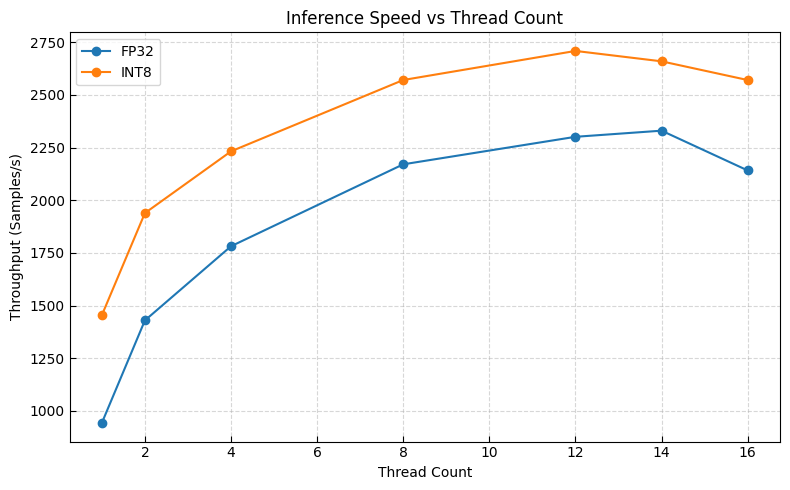

Graph saved as 'inference_speed_vs_thread_count.png'


In [3]:
f = "inference_speed_vs_thread_count.png"

# Inference Speed vs Thread Count
threads = [16, 14, 12, 8, 4, 2, 1]
fp32 = [2141.32, 2330.19, 2301.10, 2170.47, 1781.53, 1429.40, 942.51]
int8 = [2570.53, 2659.39, 2708.73, 2570.72, 2232.06, 1938.85, 1453.89]

plt.figure(figsize=(8,5))
plt.plot(threads, fp32, marker='o', label='FP32')
plt.plot(threads, int8, marker='o', label='INT8')

plt.xlabel("Thread Count")
plt.ylabel("Throughput (Samples/s)")
plt.title("Inference Speed vs Thread Count")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(direction='in', length=4)

# plt.gca().invert_xaxis()  # <-- invert x-axis

plt.tight_layout()
plt.savefig(f)
plt.show()
print(f"Graph saved as '{f}'")


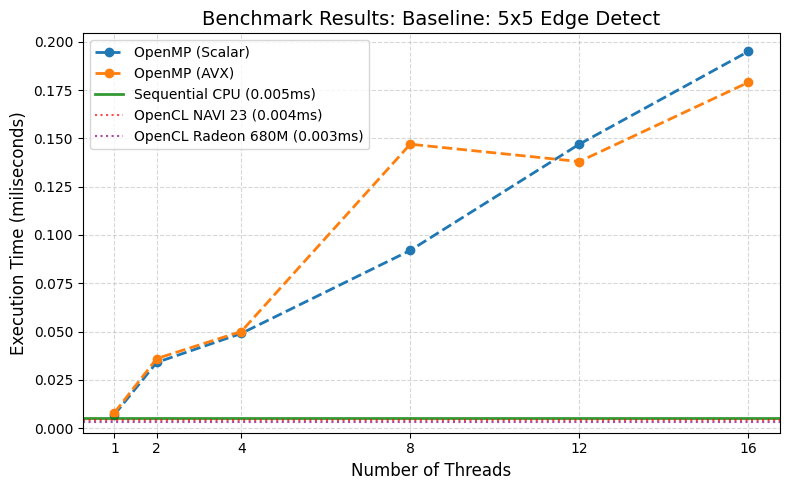

Graph saved as 'baseline_benchmark.png'


In [4]:
def generate_benchmark_graph(csv_file, filename):
    # 1. Load the dataset
    df = pd.read_csv(csv_file)
    
    # Extract the first row of data
    data = df.iloc[0]
    test_name = data['Test Case']

    # 2. Extract Baselines
    sequential_val = data['Sequential CPU']
    opencl_navi = data['OpenCL NAVI 23']
    opencl_radeon = data['OpenCL Radeon 680M']

    # 3. Extract and Parse OpenMP Data
    omp_results = []
    pattern = r'OpenMP \((\d+)T\) \((Scalar|AVX)\)'

    for col in df.columns:
        match = re.search(pattern, col)
        if match:
            threads = int(match.group(1))
            mode = match.group(2)
            value = data[col]
            omp_results.append({'Threads': threads, 'Mode': mode, 'Value': value})

    omp_df = pd.DataFrame(omp_results)

    # 4. Plotting
    plt.figure(figsize=(8, 5))

    # Plot OpenMP Lines (Dashed as requested)
    for mode in ['Scalar', 'AVX']:
        subset = omp_df[omp_df['Mode'] == mode].sort_values('Threads')
        plt.plot(subset['Threads'], subset['Value'], 
                 marker='o', linestyle='--', linewidth=2, label=f'OpenMP ({mode})')

    # Plot Baselines
    # Sequential -> Solid Line
    plt.axhline(y=sequential_val, color='green', linestyle='-', alpha=0.8, linewidth=2,
                label=f'Sequential CPU ({sequential_val:.3f}ms)')
    
    # OpenCL -> Dotted (kept distinct)
    plt.axhline(y=opencl_navi, color='red', linestyle=':', alpha=0.7, 
                label=f'OpenCL NAVI 23 ({opencl_navi:.3f}ms)')
    plt.axhline(y=opencl_radeon, color='purple', linestyle=':', alpha=0.7, 
                label=f'OpenCL Radeon 680M ({opencl_radeon:.3f}ms)')

    # Graph Formatting
    plt.title(f'Benchmark Results: {test_name}', fontsize=14)
    plt.xlabel('Number of Threads', fontsize=12)
    plt.ylabel('Execution Time (miliseconds)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(sorted(omp_df['Threads'].unique()))
    plt.legend()
    
    # Save and Show
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    print(f"Graph saved as '{filename}'")

generate_benchmark_graph('compiled/baseline_results.csv', "baseline_benchmark.png")

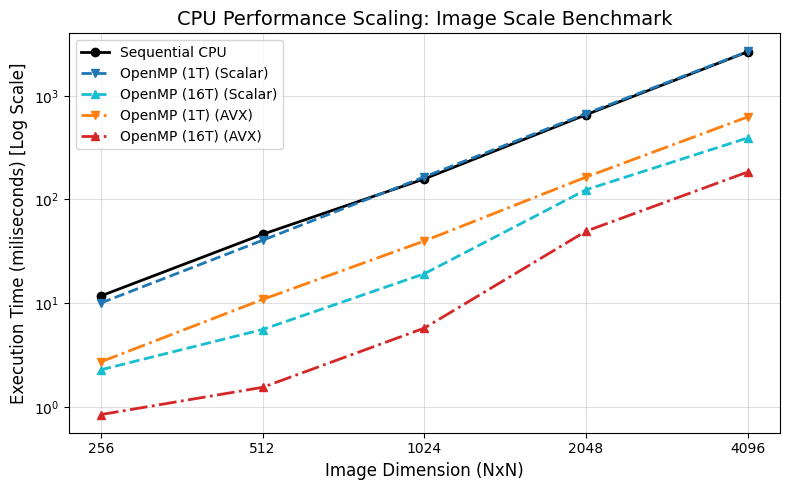

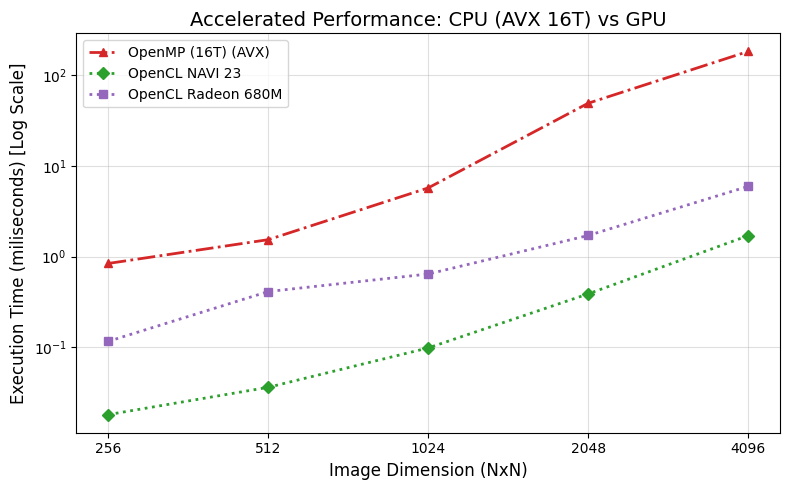

Charts saved as 'image_scale_cpu.png' and 'image_scale_cpu_vs_gpu.png'


In [5]:
def generate_scaling_graphs(csv_file):
    f1 = "image_scale_cpu.png"
    f2 = "image_scale_cpu_vs_gpu.png"
    size = (8, 5)
    # 1. Load Data
    df = pd.read_csv(csv_file)

    # 2. Extract Dimensions for X-Axis
    # Converts "Scale Image: 256x256..." -> 256
    def extract_dim(s):
        match = re.search(r'(\d+)x\d+', s)
        if match:
            return int(match.group(1))
        return 0

    df['Dimension'] = df['Test Case'].apply(extract_dim)
    df = df.sort_values('Dimension') # Ensure sorted order

    # --- Chart 1: CPU Performance (Sequential vs OpenMP) ---
    plt.figure(figsize=size)

    # Define which CPU columns to plot and their styles
    # We pick a representative set to avoid overcrowding
    cpu_lines = {
        'Sequential CPU':        {'style': '-',  'marker': 'o', 'color': 'black'},
        'OpenMP (1T) (Scalar)':  {'style': '--', 'marker': 'v', 'color': 'tab:blue'},
        'OpenMP (16T) (Scalar)': {'style': '--', 'marker': '^', 'color': 'tab:cyan'},
        'OpenMP (1T) (AVX)':     {'style': '-.', 'marker': 'v', 'color': 'tab:orange'},
        'OpenMP (16T) (AVX)':    {'style': '-.', 'marker': '^', 'color': 'tab:red'}
    }

    for col_name, style in cpu_lines.items():
        plt.plot(df['Dimension'], df[col_name], label=col_name, 
                 linestyle=style['style'], marker=style['marker'], color=style['color'], linewidth=2)

    plt.title('CPU Performance Scaling: Image Scale Benchmark', fontsize=14)
    plt.xlabel('Image Dimension (NxN)', fontsize=12)
    plt.ylabel('Execution Time (miliseconds) [Log Scale]', fontsize=12)
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.4)
    
    # Log scales work best for scaling benchmarks
    plt.xscale('log')
    plt.yscale('log')
    
    # Force X-axis ticks to match our data points exactly
    plt.xticks(df['Dimension'], labels=df['Dimension'])
    plt.minorticks_off() # distinct ticks for our specific dimensions are cleaner
    
    plt.tight_layout()
    plt.savefig(f1)
    plt.show()


    # --- Chart 2: Best CPU vs GPU ---
    plt.figure(figsize=size)

    gpu_lines = {
        'OpenMP (16T) (AVX)': {'style': '-.', 'marker': '^', 'color': 'tab:red'}, # Best CPU
        'OpenCL NAVI 23':     {'style': ':',  'marker': 'D', 'color': 'tab:green'},
        'OpenCL Radeon 680M': {'style': ':',  'marker': 's', 'color': 'tab:purple'}
    }

    for col_name, style in gpu_lines.items():
        plt.plot(df['Dimension'], df[col_name], label=col_name, 
                 linestyle=style['style'], marker=style['marker'], color=style['color'], linewidth=2)

    plt.title('Accelerated Performance: CPU (AVX 16T) vs GPU', fontsize=14)
    plt.xlabel('Image Dimension (NxN)', fontsize=12)
    plt.ylabel('Execution Time (miliseconds) [Log Scale]', fontsize=12)
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.4)
    
    plt.xscale('log')
    plt.yscale('log')
    
    plt.xticks(df['Dimension'], labels=df['Dimension'])
    plt.minorticks_off()

    plt.tight_layout()
    plt.savefig(f2)
    plt.show()

    print(f"Charts saved as '{f1}' and '{f2}'")


generate_scaling_graphs('compiled/scale_image_results.csv')

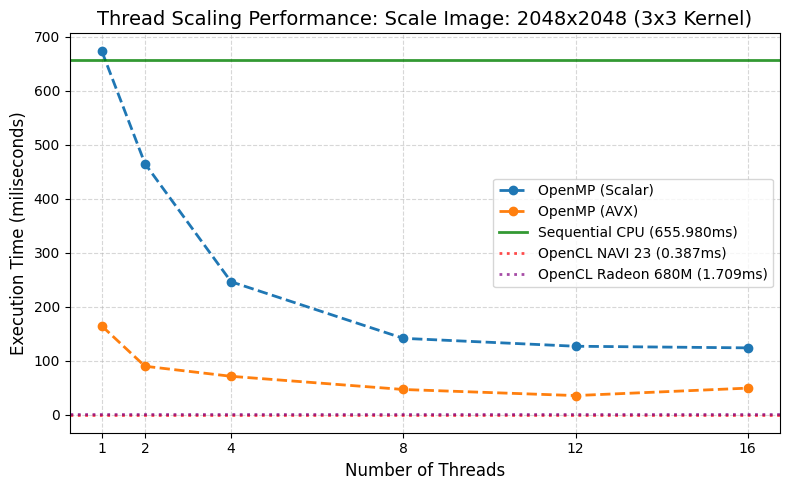

Graph saved as 'image_scale_2048_speed_vs_threads.png'


In [10]:
def generate_2048_thread_scaling(csv_file):
    f = "image_scale_2048_speed_vs_threads.png"
    # 1. Load Data
    df = pd.read_csv(csv_file)

    # 2. Select the specific row for 2048x2048
    target_test = 'Scale Image: 2048x2048 (3x3 Kernel)'
    # Check if row exists to avoid errors
    if target_test not in df['Test Case'].values:
        print(f"Error: '{target_test}' not found in CSV.")
        return

    row = df[df['Test Case'] == target_test].iloc[0]

    # 3. Extract Baselines
    sequential_val = row['Sequential CPU']
    opencl_navi = row['OpenCL NAVI 23']
    opencl_radeon = row['OpenCL Radeon 680M']

    # 4. Parse OpenMP Columns
    omp_data = []
    pattern = r'OpenMP \((\d+)T\) \((Scalar|AVX)\)'

    for col in df.columns:
        match = re.search(pattern, col)
        if match:
            threads = int(match.group(1))
            mode = match.group(2)
            val = row[col]
            omp_data.append({'Threads': threads, 'Mode': mode, 'Value': val})

    omp_df = pd.DataFrame(omp_data)

    # 5. Plotting
    plt.figure(figsize=(8, 5))

    # Plot OpenMP (Dashed Lines)
    for mode in ['Scalar', 'AVX']:
        subset = omp_df[omp_df['Mode'] == mode].sort_values('Threads')
        plt.plot(subset['Threads'], subset['Value'], 
                 marker='o', linestyle='--', linewidth=2, label=f'OpenMP ({mode})')

    # Plot Baselines
    # Sequential (Solid Line)
    plt.axhline(y=sequential_val, color='green', linestyle='-', linewidth=2, alpha=0.8,
                label=f'Sequential CPU ({sequential_val:.3f}ms)')
    
    # GPU Baselines (Dotted Lines)
    plt.axhline(y=opencl_navi, color='red', linestyle=':', linewidth=2, alpha=0.7,
                label=f'OpenCL NAVI 23 ({opencl_navi:.3f}ms)')
    plt.axhline(y=opencl_radeon, color='purple', linestyle=':', linewidth=2, alpha=0.7,
                label=f'OpenCL Radeon 680M ({opencl_radeon:.3f}ms)')

    # Formatting
    plt.title(f'Thread Scaling Performance: {target_test}', fontsize=14)
    plt.xlabel('Number of Threads', fontsize=12)
    plt.ylabel('Execution Time (miliseconds)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(sorted(omp_df['Threads'].unique())) # Ensure all thread counts are on axis

    plt.tight_layout()
    plt.savefig(f)
    plt.show()
    print(f"Graph saved as '{f}'")


generate_2048_thread_scaling('compiled/scale_image_results.csv')

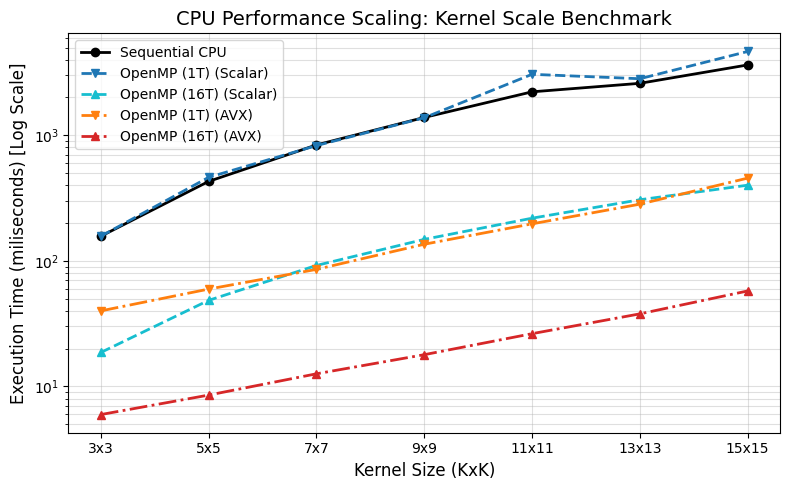

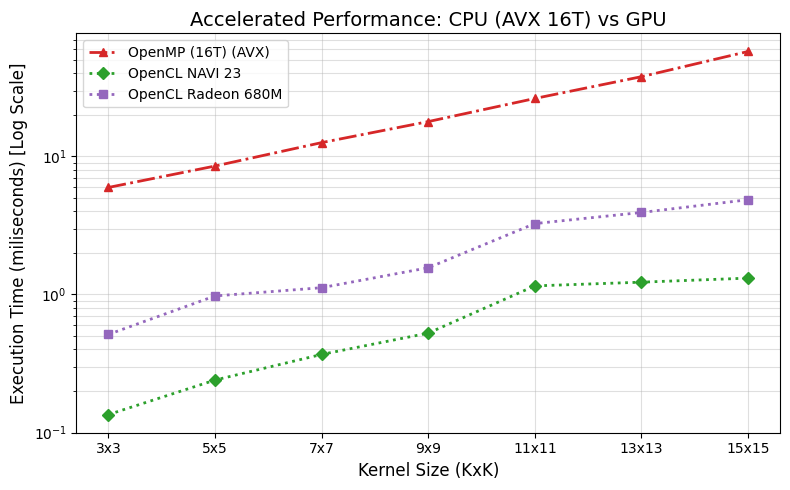

Charts saved as 'kernel_scale_cpu.png' and 'kernel_scale_cpu_vs_gpu.png'


In [7]:
def generate_kernel_scaling_graphs(csv_file):
    f1 = "kernel_scale_cpu.png"
    f2 = "kernel_scale_cpu_vs_gpu.png"
    size = (8, 5)
    # 1. Load Data
    df = pd.read_csv(csv_file)

    # 2. Extract Kernel Dimension (3, 5, 7...)
    def extract_kernel_dim(s):
        # Matches "Scale Kernel: 3x3..." -> 3
        match = re.search(r'Scale Kernel: (\d+)x\d+', s)
        if match:
            return int(match.group(1))
        return 0

    df['KernelSize'] = df['Test Case'].apply(extract_kernel_dim)
    df = df.sort_values('KernelSize')

    # --- Chart 1: CPU Performance Scaling ---
    plt.figure(figsize=size)

    cpu_columns = {
        'Sequential CPU':        {'style': '-',  'marker': 'o', 'color': 'black'},
        'OpenMP (1T) (Scalar)':  {'style': '--', 'marker': 'v', 'color': 'tab:blue'},
        'OpenMP (16T) (Scalar)': {'style': '--', 'marker': '^', 'color': 'tab:cyan'},
        'OpenMP (1T) (AVX)':     {'style': '-.', 'marker': 'v', 'color': 'tab:orange'},
        'OpenMP (16T) (AVX)':    {'style': '-.', 'marker': '^', 'color': 'tab:red'}
    }

    for col, params in cpu_columns.items():
        plt.plot(df['KernelSize'], df[col], label=col, 
                 linestyle=params['style'], marker=params['marker'], 
                 color=params['color'], linewidth=2)

    plt.title('CPU Performance Scaling: Kernel Scale Benchmark', fontsize=14)
    plt.xlabel('Kernel Size (KxK)', fontsize=12)
    plt.ylabel('Execution Time (miliseconds) [Log Scale]', fontsize=12)
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.4)
    
    # Linear X-axis for kernel sizes (3, 5, 7...) is usually better than log
    plt.xscale('linear') 
    plt.yscale('log')
    
    # Set explicit ticks for 3x3, 5x5, etc.
    plt.xticks(df['KernelSize'], labels=[f'{k}x{k}' for k in df['KernelSize']])
    
    plt.tight_layout()
    plt.savefig(f1)
    plt.show()

    # --- Chart 2: CPU (Best) vs GPU ---
    plt.figure(figsize=size)

    gpu_columns = {
        'OpenMP (16T) (AVX)': {'style': '-.', 'marker': '^', 'color': 'tab:red'},
        'OpenCL NAVI 23':     {'style': ':',  'marker': 'D', 'color': 'tab:green'},
        'OpenCL Radeon 680M': {'style': ':',  'marker': 's', 'color': 'tab:purple'}
    }

    for col, params in gpu_columns.items():
        plt.plot(df['KernelSize'], df[col], label=col, 
                 linestyle=params['style'], marker=params['marker'], 
                 color=params['color'], linewidth=2)

    plt.title('Accelerated Performance: CPU (AVX 16T) vs GPU', fontsize=14)
    plt.xlabel('Kernel Size (KxK)', fontsize=12)
    plt.ylabel('Execution Time (miliseconds) [Log Scale]', fontsize=12)
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.4)
    
    plt.xscale('linear')
    plt.yscale('log')
    plt.xticks(df['KernelSize'], labels=[f'{k}x{k}' for k in df['KernelSize']])

    plt.tight_layout()
    plt.savefig(f2)
    plt.show()
    
    print(f"Charts saved as '{f1}' and '{f2}'")

if __name__ == "__main__":
    generate_kernel_scaling_graphs('compiled/scale_kernel_results.csv')

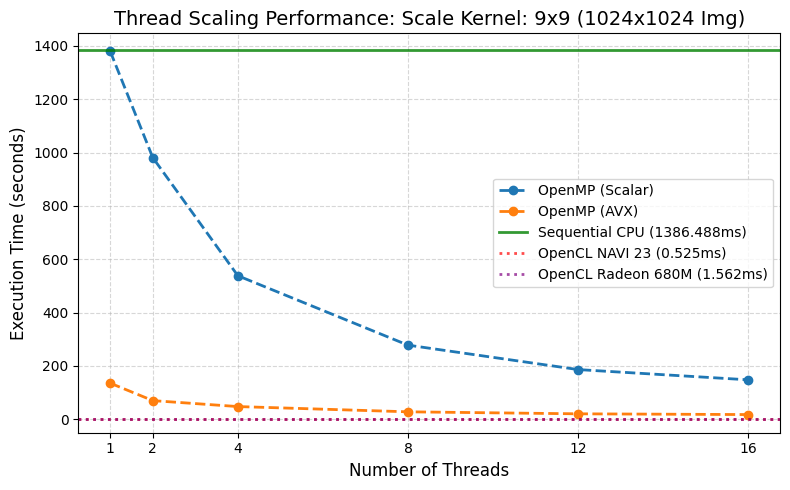

Graph saved as 'kernel_scale_9x9_speed_vs_thread.png'


In [8]:
def generate_9x9_thread_scaling(csv_file):
    f="kernel_scale_9x9_speed_vs_thread.png"
    # 1. Load Data
    df = pd.read_csv(csv_file)

    # 2. Find the 9x9 Kernel row
    # Using string search is safer than hardcoding the full name
    try:
        target_row = df[df['Test Case'].str.contains('9x9')].iloc[0]
        test_name = target_row['Test Case']
    except IndexError:
        print("Error: 9x9 Kernel test case not found.")
        return

    # 3. Extract Baselines
    sequential_val = target_row['Sequential CPU']
    opencl_navi = target_row['OpenCL NAVI 23']
    opencl_radeon = target_row['OpenCL Radeon 680M']

    # 4. Parse OpenMP Columns
    omp_data = []
    pattern = r'OpenMP \((\d+)T\) \((Scalar|AVX)\)'

    for col in df.columns:
        match = re.search(pattern, col)
        if match:
            threads = int(match.group(1))
            mode = match.group(2)
            val = target_row[col]
            omp_data.append({'Threads': threads, 'Mode': mode, 'Value': val})

    omp_df = pd.DataFrame(omp_data)

    # 5. Plotting
    plt.figure(figsize=(8, 5))

    # Plot OpenMP (Dashed Lines as requested)
    for mode in ['Scalar', 'AVX']:
        subset = omp_df[omp_df['Mode'] == mode].sort_values('Threads')
        plt.plot(subset['Threads'], subset['Value'], 
                 marker='o', linestyle='--', linewidth=2, label=f'OpenMP ({mode})')

    # Plot Baselines
    # Sequential -> Solid Line
    plt.axhline(y=sequential_val, color='green', linestyle='-', linewidth=2, alpha=0.8,
                label=f'Sequential CPU ({sequential_val:.3f}ms)')
    
    # GPU -> Dotted Lines
    plt.axhline(y=opencl_navi, color='red', linestyle=':', linewidth=2, alpha=0.7,
                label=f'OpenCL NAVI 23 ({opencl_navi:.3f}ms)')
    plt.axhline(y=opencl_radeon, color='purple', linestyle=':', linewidth=2, alpha=0.7,
                label=f'OpenCL Radeon 680M ({opencl_radeon:.3f}ms)')

    # Formatting
    plt.title(f'Thread Scaling Performance: {test_name}', fontsize=14)
    plt.xlabel('Number of Threads', fontsize=12)
    plt.ylabel('Execution Time (seconds)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(sorted(omp_df['Threads'].unique()))

    plt.tight_layout()
    plt.savefig(f)
    plt.show()
    print(f"Graph saved as '{f}'")


generate_9x9_thread_scaling('compiled/scale_kernel_results.csv')